# Imports

## Environment Variables

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
ANTHROPIC_MODEL = os.getenv("ANTHROPIC_MODEL")
OPENAI_MODEL = os.getenv("OPENAI_MODEL")

# Verify keys are loaded
print(f'Anthropic API Key loaded: {bool(os.getenv("ANTHROPIC_API_KEY"))}\nAnthropic model: {os.getenv("ANTHROPIC_MODEL")}')
print(f'OpenAI API Key loaded: {bool(os.getenv("OPENAI_API_KEY"))}\nOpenAI model: {os.getenv("OPENAI_MODEL")}')
print(OPENAI_MODEL)

Anthropic API Key loaded: True
Anthropic model: claude-sonnet-4-20250514
OpenAI API Key loaded: True
OpenAI model: gpt-4o-mini
gpt-4o-mini


## Packages

In [2]:
from typing import Literal, TypedDict
import json
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

# Configure LLM
&rarr; choose anthropic / openai 

In [3]:
def get_llm(provider: Literal["anthropic", "openai"] = "openai"):
    """Get LLM instance based on provider choice"""
    if provider == "anthropic":
        return ChatAnthropic(
            model=ANTHROPIC_MODEL,
            temperature=0.7,
            max_tokens=1024
        )
    elif provider == "openai":
        return ChatOpenAI(
            model=OPENAI_MODEL,
            temperature=0.7,
            max_tokens=1024
        )
    else:
        raise ValueError(f"Unknown provider: {provider}")

# Choose your provider here
LLM_PROVIDER = "openai"  # Change to "anthropic" if you prefer
llm = get_llm(LLM_PROVIDER)

print(f"Using {LLM_PROVIDER.upper()} as LLM provider")

Using OPENAI as LLM provider


# States 

In [4]:
# State = the data that flows through the workflow

class State(TypedDict):
    messages: list                  # Conversation history
    name: str                       # Employee name
    start_date: str                 # Start date
    end_date: str                   # End date (optional)
    work_hours: float               # Weekly work hours
    salary: float                   # Salary
    info_complete: bool             # All info collected?
    human_decision: str             # "approve" or "reject"
    is_update: bool                 # New entry or update existing?

# Nodes
NB: Chatbots are nodes

In [5]:
# System prompt for the chatbot
SYSTEM_PROMPT = """You are Lola, a friendly HR assistant collecting employee information.

You need to collect these fields (one at a time, conversationally):
1. name - Employee's full name
2. start_date - Employment start date (normalize to YYYY-MM-DD)
3. end_date - Employment end date, can be empty if ongoing (normalize to YYYY-MM-DD or "ongoing")
4. work_hours - Weekly work hours (as a number)
5. salary - Annual salary in CHF (as a number)


Important rules:
- Be friendly and conversational
- Ask for ONE piece of information at a time
- The user may answer in ANY date format or language (e.g. "1st of April 2026", "1. April 2026", German or English).
- You must ALWAYS normalize dates to ISO format: YYYY-MM-DD.
- If no end date exists, output null.
- Employee names must be properly capitalized: only the first letter of each word should be uppercase,
  and the rest lowercase. Examples:
  * "Zacharias HAeusgen" → "Zacharias Haeusgen"
  * "john SMITH" → "John Smith"
  * "MARIA garcia" → "Maria Garcia"
- Salary can be provided in any format (e.g., "50k EUR a year", "40K USD a year", "30k CHF a year").
- You must ALWAYS convert the salary to CHF (Swiss Francs) as an annual integer amount.
- Use these approximate conversion rates: 1 EUR = 0.95 CHF, 1 USD = 0.88 CHF, 1 GBP = 1.12 CHF
- Ask follow-up questions only if information is missing or unclear.

When you have ALL the information, respond with ONLY a JSON object:
{"name": "...", "start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD or ongoing", "work_hours": number, "salary": number, "complete": true}

If information is still missing, just chat normally (no JSON).
"""

# Keywords to exit the conversation
EXIT_KEYWORDS = {"exit", "bye", "quit", "stop", "cancel", "goodbye", "end"}


def validate_data(data: dict) -> list[str]:
    """Validate collected data. Returns list of error messages."""
    errors = []
    
    # 1. Minimum yearly salary 20000 CHF
    salary = data.get("salary", 0)
    if salary < 20000:
        errors.append(f"Salary must be at least 20,000 CHF (got {salary})")
    
    # 2. Start date must be after 2010
    start_date = data.get("start_date", "")
    if start_date:
        start_year = int(start_date.split("-")[0])
        if start_year <= 2010:
            errors.append(f"Start date must be after 2010 (got {start_date})")
    
    # 3. End date must be after start date (if not ongoing)
    end_date = data.get("end_date", "")
    if end_date and end_date.lower() != "ongoing" and start_date:
        if end_date <= start_date:
            errors.append(f"End date ({end_date}) must be after start date ({start_date})")
    
    return errors


# NODE 1: Chatbot - collects employee info
def chatbot(state: State) -> State:
    """Talks to user, collects: name, start_date, end_date, work_hours, salary"""
    
    messages = state.get("messages", [])
    
    # Check if last user message was an exit keyword
    if messages and messages[-1]["role"] == "user":
        last_input = messages[-1]["content"].lower().strip()
        if last_input in EXIT_KEYWORDS:
            print("👋 Conversation ended by user.")
            return {
                **state,
                "info_complete": True,
                "human_decision": "cancel",
            }
    
    # Build message list for LLM
    llm_messages = [SystemMessage(content=SYSTEM_PROMPT)]
    for msg in messages:
        if msg["role"] == "user":
            llm_messages.append(HumanMessage(content=msg["content"]))
        else:
            llm_messages.append(AIMessage(content=msg["content"]))
    
    # If no conversation yet, start with greeting
    if not messages:
        llm_messages.append(HumanMessage(content="Hi, I need to enter employee information."))
    
    # Call LLM
    response = llm.invoke(llm_messages)
    assistant_message = response.content
    
    print(f"🤖 Lola: {assistant_message}")
    
    # Try to parse JSON (means all info collected)
    try:
        data = json.loads(assistant_message)
        if data.get("complete"):
            # Validate the data
            errors = validate_data(data)
            
            if errors:
                # Validation failed - tell user and continue
                error_msg = "⚠️ Validation errors:\n" + "\n".join(f"  - {e}" for e in errors)
                print(error_msg)
                
                # Ask LLM to correct
                correction_prompt = f"The data has validation errors: {'; '.join(errors)}. Please ask the user to correct these values."
                user_input = input("You: ")
                
                new_messages = messages + [
                    {"role": "assistant", "content": assistant_message},
                    {"role": "system", "content": error_msg},
                    {"role": "user", "content": user_input},
                ]
                return {
                    **state,
                    "messages": new_messages,
                    "info_complete": False,
                }
            
            # Validation passed
            return {
                **state,
                "messages": messages + [{"role": "assistant", "content": assistant_message}],
                "name": data.get("name", ""),
                "start_date": data.get("start_date", ""),
                "end_date": data.get("end_date", ""),
                "work_hours": float(data.get("work_hours", 0)),
                "salary": float(data.get("salary", 0)),
                "info_complete": True,
            }
    except json.JSONDecodeError:
        pass
    
    # Get user input
    user_input = input("You: ")
    
    # Update messages
    new_messages = messages + [
        {"role": "assistant", "content": assistant_message},
        {"role": "user", "content": user_input},
    ]
    
    return {
        **state,
        "messages": new_messages,
        "info_complete": False,
    }

In [6]:
# NODE 2: Human verification - PAUSES for human to review
def human_verification(state: State) -> State:
    """Shows collected data, waits for human to approve or reject"""
    
    print("⏸️  [human_verification] Please review the data:")
    print(f"    Name: {state.get('name')}")
    print(f"    Start: {state.get('start_date')}")
    print(f"    End: {state.get('end_date')}")
    print(f"    Hours: {state.get('work_hours')}")
    print(f"    Salary: {state.get('salary')}")
    
    return state

In [7]:
# NODE 3: Create new entry
def create_entry(state: State) -> State:
    """Creates a new employee record"""
    
    # TODO: Add database insert logic here
    print(f"✅ [create_entry] Will create new entry for: {state.get('name')}")
    return state


# NODE 4: Update existing entry  
def update_entry(state: State) -> State:
    """Updates an existing employee record"""
    
    # TODO: Add database update logic here
    print(f"✅ [update_entry] Will update entry for: {state.get('name')}")
    return state

In [8]:
# ROUTER 1: After chatbot - keep collecting or go to verification?
def route_after_chatbot(state: State) -> str:
    # If cancelled, skip verification and end
    if state.get("human_decision") == "cancel":
        return END
    if state.get("info_complete"):
        return "human_verification"  # All info collected -> verify
    return "chatbot"                 # Missing info -> keep asking


# ROUTER 2: After human verification - what did human decide?
def route_after_verification(state: State) -> str:
    decision = state.get("human_decision")
    
    if decision == "reject":
        return "chatbot"             # Rejected -> go back to fix
    
    if decision == "approve":
        if state.get("is_update"):
            return "update_entry"    # Update existing
        return "create_entry"        # Create new
    
    return "chatbot"                 # No decision -> go back

# Workflow

In [9]:
# Build the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("chatbot", chatbot)
workflow.add_node("human_verification", human_verification)
workflow.add_node("create_entry", create_entry)
workflow.add_node("update_entry", update_entry)

# Add edges (connections)
workflow.add_edge(START, "chatbot")                    # START -> chatbot

workflow.add_conditional_edges(                        # chatbot -> ? (depends on info_complete)
    "chatbot",
    route_after_chatbot,
    ["chatbot", "human_verification", END]             # Added END for cancel
)

workflow.add_conditional_edges(                        # human_verification -> ? (depends on decision)
    "human_verification", 
    route_after_verification,
    ["chatbot", "create_entry", "update_entry"]
)

workflow.add_edge("create_entry", END)                 # create_entry -> END
workflow.add_edge("update_entry", END)                 # update_entry -> END

In [10]:
# Compile with human-in-the-loop (pauses at human_verification)
memory = MemorySaver()

app = workflow.compile(
    checkpointer=memory,
    interrupt_before=["human_verification"]  # <-- PAUSE here for human review
)

# Visualize graph

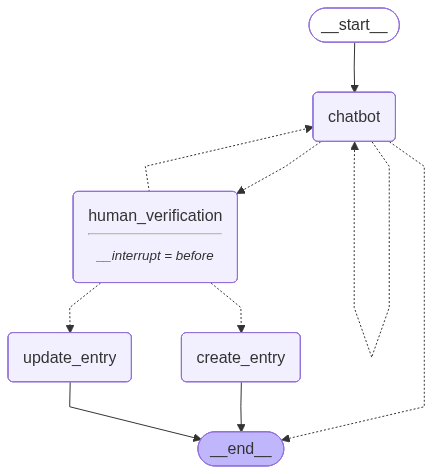

In [11]:
# Visualize the workflow
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

# Run the workflow

In [12]:
# Initial state (empty)
initial_state = {
    "messages": [],
    "name": "",
    "start_date": "",
    "end_date": "",
    "work_hours": 0.0,
    "salary": 0.0,
    "info_complete": False,
    "human_decision": "",
    "is_update": False,
}

# Config with thread ID (needed for checkpointing)
config = {"configurable": {"thread_id": "test-1"}}

# Run until it pauses at human_verification
for event in app.stream(initial_state, config):
    print(event)

🤖 Lola: Hi there! I'd be happy to help you with that. Let's get started! Could you please provide the employee's full name?
{'chatbot': {'messages': [{'role': 'assistant', 'content': "Hi there! I'd be happy to help you with that. Let's get started! Could you please provide the employee's full name?"}, {'role': 'user', 'content': 'sissi OttOvonCat'}], 'name': '', 'start_date': '', 'end_date': '', 'work_hours': 0.0, 'salary': 0.0, 'info_complete': False, 'human_decision': '', 'is_update': False}}
🤖 Lola: Thank you! Just to make sure I have it right, I'll format the name properly. The name is "Sissi Ottovoncat." 

Next, could you please tell me the employment start date?
{'chatbot': {'messages': [{'role': 'assistant', 'content': "Hi there! I'd be happy to help you with that. Let's get started! Could you please provide the employee's full name?"}, {'role': 'user', 'content': 'sissi OttOvonCat'}, {'role': 'assistant', 'content': 'Thank you! Just to make sure I have it right, I\'ll format th

In [13]:
# After human reviews, update state and resume
# Example: human approves creating a new entry

app.update_state(config, {"human_decision": "approve", "is_update": False})

# Resume the workflow
for event in app.stream(None, config):
    print(event)

⏸️  [human_verification] Please review the data:
    Name: 
    Start: 
    End: 
    Hours: 0.0
    Salary: 0.0
{'human_verification': {'messages': [{'role': 'assistant', 'content': "Hi there! I'd be happy to help you with that. Let's get started! Could you please provide the employee's full name?"}, {'role': 'user', 'content': 'sissi OttOvonCat'}, {'role': 'assistant', 'content': 'Thank you! Just to make sure I have it right, I\'ll format the name properly. The name is "Sissi Ottovoncat." \n\nNext, could you please tell me the employment start date?'}, {'role': 'user', 'content': 'next monday'}, {'role': 'assistant', 'content': 'Got it! Since next Monday is in the future, I\'ll need to know the exact date. Could you tell me the date in a specific format, like "YYYY-MM-DD" or something similar?'}, {'role': 'user', 'content': '12 jan 26'}, {'role': 'assistant', 'content': 'Thank you! I\'ll convert that to the proper format. The start date is "2026-01-12."\n\nNow, could you share the em